# Getting input data into the correct form

We use the same example data as from [PredictCode](https://github.com/QuantCrimAtLeeds/PredictCode/tree/master/quick_start).  This is extracted from the [Chicago data](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2) but simplified to make the following easier to explain.

This notebook takes a step by step approach.  See the notebook `example` for a more streamlined presentation.

## Read the data in python

We need to:

- Understand the input data
- Read the timestamps
- Read the coordinates, and project them if necessary from Longitude and Latitude

We use `pandas` to make life a bit easier.

In [1]:
import pandas as pd

In [2]:
frame = pd.read_csv("example.csv")
frame.head()

,Case Number,Date,Block,Primary Type,Latitude,Longitude
0,HZ242280,04/27/2016 01:44:00 PM,073XX S COTTAGE GROVE AVE,BATTERY,41.761773,-87.605479
1,HZ251168,05/04/2016 02:12:00 PM,065XX S DREXEL AVE,OTHER OFFENSE,41.776258,-87.603401
2,HZ251809,05/05/2016 12:30:00 AM,032XX S STATE ST,THEFT,41.836344,-87.626740
3,HZ251803,05/05/2016 01:13:00 AM,008XX E 63RD ST,ROBBERY,41.780439,-87.603728
4,HZ254409,05/06/2016 08:07:00 PM,073XX S DORCHESTER AVE,CRIMINAL DAMAGE,41.761767,-87.590880


### Read the timestamps

We need to read the `date` field into a python `datetime` object.  We use the library [`python-dateutil`](https://dateutil.readthedocs.io/en/stable/) which makes converting timestamps really easy.

We also continue to use pandas, rather than reading the csv file directly.  We select the `Date` column with

    frame.Date
    
and then use `map` which applies a function to each row of that column.  The function we use is `dateutil.parser.parse` which takes the string timestamp, and converts it into a Python object.

In [3]:
import dateutil.parser

timestamps = frame.Date.map(dateutil.parser.parse)
timestamps[:5]

0   2016-04-27 13:44:00
1   2016-05-04 14:12:00
2   2016-05-05 00:30:00
3   2016-05-05 01:13:00
4   2016-05-06 20:07:00
Name: Date, dtype: datetime64[ns]

## Project the coordinates

We use the [`pyproj`](https://pypi.python.org/pypi/pyproj) package which supports standard projection methods.  We use [EPSG:2790](http://spatialreference.org/ref/epsg/2790/) for Chicago.

In [4]:
import pyproj
proj = pyproj.Proj({"init":"EPSG:2790"})

We cannot use `map` now, as we need to combine the two columns of Longitude and Latitude.  Fortunately, we can parse lists to a `Proj` object.  The code

    frame.Longitude.values
    
selects the `Longitude` column, and then selects just the values.  (We sometimes need to do this: if we don't, `pyproj` gets confused).

In [5]:
xcoords, ycoords = proj(frame.Longitude.values, frame.Latitude.values)
xcoords[:5], ycoords[:5]

(array([ 360526.39062028,  360685.49654452,  358690.27181414,
         360654.40692587,  361740.41144432]),
 array([ 565899.21264356,  567509.47416798,  574166.92918153,
         567973.68552269,  565908.96619951]))

## Combine

`open_cp` has its own data container which we build here.  We print the number of data points, and the time range.  They look okay.

In [6]:
import open_cp.data

points = open_cp.data.TimedPoints.from_coords(timestamps, xcoords, ycoords)

In [7]:
points.number_data_points

1000

In [8]:
points.time_range

(numpy.datetime64('2016-01-01T01:00:00.000'),
 numpy.datetime64('2016-12-31T21:15:00.000'))

# Load some geometry and form a grid

We now load the outline of the South side of Chicago, using `geopandas` for convenience.

In [12]:
import geopandas as gpd

In [14]:
frame = gpd.read_file("SouthSide")
frame

,geometry,name
0,"POLYGON ((365647.3845872784 565208.9811670227,...",South Side


In [17]:
geo = list(frame.geometry)[0]

## Visualise

We use the package `descartes` and the usual `matplotlib` library to view the outline, and plot the points over it.

In [19]:
import descartes
%matplotlib inline
import matplotlib.pyplot as plt

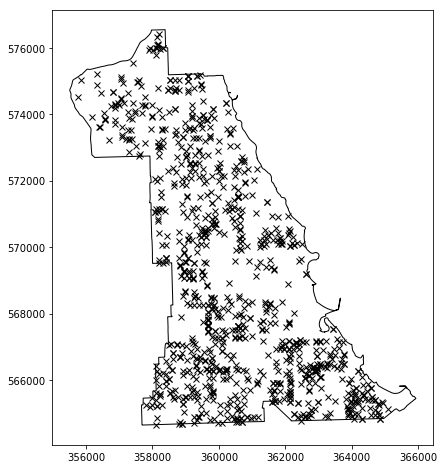

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect(1)
ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
ax.scatter(xcoords, ycoords, marker="x", color="black", linewidth=1)

## Make a grid

For some of the SEPP methods, and for making any prediction, we need a grid.  `open_cp` provides some ways to do this.

In [24]:
import open_cp.data
import open_cp.geometry

grid = open_cp.data.Grid(xsize=150, ysize=150, xoffset=0, yoffset=0)
grid = open_cp.geometry.mask_grid_by_intersection(geo, grid)

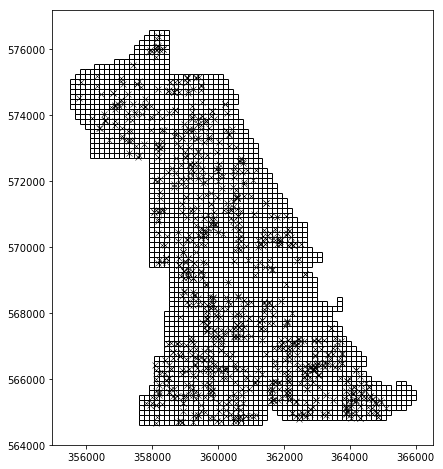

In [36]:
import open_cp.plot
import matplotlib.collections

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect(1)
lc = matplotlib.collections.LineCollection(open_cp.plot.lines_from_grid(grid), color="black", linewidth=1)
ax.add_collection(lc)
ax.scatter(xcoords, ycoords, marker="x", color="black", linewidth=0.5)

# Run a simple SEPP method on this data

With this example data, we don't expect to learn anything...

In [46]:
import sepp.sepp_grid
import datetime

In [47]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1))

In [48]:
model

ExpDecayModel(T=365.9583333333333, theta=2.2169208559939183e-05, omega=1.3824669264033764, mu size=(80, 70)

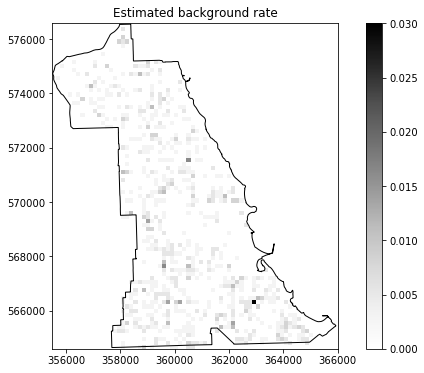

In [49]:
fig, ax = plt.subplots(figsize=(10,6))

ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
ax.set_aspect(1)
pred = trainer.prediction_from_background(model)
mappable = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("Estimated background rate")
None

## And an example of a non-grid based method

In [61]:
import sepp.kernels
import sepp.sepp_full
import numpy as np
import scipy.stats

In [52]:
tk_time_prov = sepp.kernels.FixedBandwidthKernelProvider(1)
tk_space_prov = sepp.kernels.FixedBandwidthKernelProvider(20, cutoff=750)
back_ker_prov = sepp.kernels.FixedBandwidthKernelProvider(100)
opt_fac = sepp.sepp_full.Optimiser1Factory(back_ker_prov, tk_time_prov, tk_space_prov)
trainer = sepp.sepp_full.Trainer1(opt_fac)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=5)
model

Model1(T=365.9583333333333, mu=2.5860284422997024, background=<open_cp.kernels.GaussianBase object at 0x0000020B59ED2470>, theta=0.05362134130340474, trigger=<open_cp.kernels.Reflect1D object at 0x0000020B59ED2630>,<open_cp.kernels.GaussianBase object at 0x0000020B58D95198>

Sorry, a load of code to produce some interesting plots...

In [62]:
def compute_plot_kde(ker, size):
    x = np.linspace(-size, size, 151)
    y = x
    xcs, ycs = np.meshgrid(x, y)
    z = ker([xcs.flatten(), ycs.flatten()])
    z = z.reshape(xcs.shape)
    return x, y, z

def plot_kde(ax, ker, size, postprocess=None):
    x, y, z = compute_plot_kde(ker, size)
    if postprocess is not None:
        z = postprocess(z)
    return ax.pcolormesh(x,y,z, cmap="Greys", rasterized=True)

def backup_limits(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    return xmin, xmax, ymin, ymax

def set_limits(ax, xmin, xmax, ymin, ymax):
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    
def plot(model, space_size=35, time_size=100, space_floor=None):
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    ax = axes[0]
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    bpred = open_cp.predictors.grid_prediction_from_kernel(model.background_kernel, grid.region(), grid.xsize)
    #bpred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)
    m = ax.pcolor(*bpred.mesh_data(), bpred.intensity_matrix, cmap="Greys", rasterized=True)
    cb = fig.colorbar(m, ax=ax)

    ax = axes[1]
    x = np.linspace(0, time_size, 200)
    y = model.theta * model.trigger_time_kernel(x)
    ax.plot(x, y, color="black")
    ax.set(xlabel="Days", ylabel="Trigger risk")
    y = np.max(y)
    for t in range(0, time_size+1):
        ax.plot([t,t],[0,y], color="grey", linewidth=0.5, linestyle="--", zorder=-10)

    pp = None
    if space_floor is not None:
        pp = lambda z : np.log(space_floor + z)
    m = plot_kde(axes[2], model.trigger_space_kernel, space_size, pp)
    plt.colorbar(m, ax=axes[2])
        
    fig.tight_layout()
    return fig

def plot_scatter_triggers(backgrounds, trigger_deltas):
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    def add_kde(ax, pts):
        xmin, xmax, ymin, ymax = backup_limits(ax)
        x = np.linspace(xmin, xmax, 151)
        y = np.linspace(ymin, ymax, 151)
        xcs, ycs = np.meshgrid(x, y)
        ker = scipy.stats.kde.gaussian_kde(pts)
        z = ker([xcs.flatten(), ycs.flatten()])
        z = z.reshape(xcs.shape)
        z = np.log(np.exp(-15)+z)
        m = ax.pcolorfast(x,y,z, cmap="Greys", rasterized=True, alpha=0.7, zorder=-10)

    ax = axes[0]
    pts = trigger_deltas[1:]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set_title("Space trigger points")

    ax = axes[1]
    pts = trigger_deltas[[0,1]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="x coord")#, xlim=[0,200])

    ax = axes[2]
    pts = trigger_deltas[[0,2]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="y coord")

    fig.tight_layout()
    return fig

def scatter_triggers(trainer, model, predict_time):
    backgrounds, trigger_deltas = trainer.sample_to_points(model, predict_time)
    return plot_scatter_triggers(backgrounds, trigger_deltas), backgrounds, trigger_deltas

We plot the background rate, and the predicted trigger components in time and space

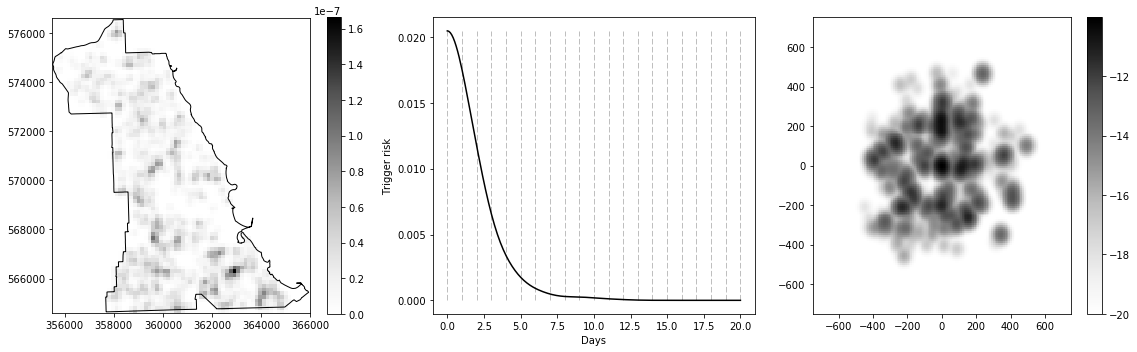

In [63]:
fig = plot(model, space_size=750, time_size=20, space_floor=np.exp(-20))

It can be quite hard to think what the above means.  Instead, we take a "sample" of the process, and decide (probabilisticly) which events are background, and which are "triggered".

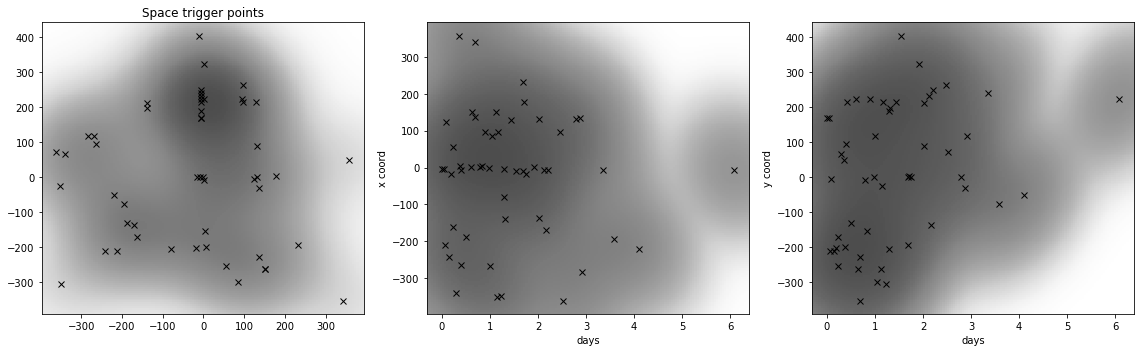

In [64]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))